In [1]:
import random
import warnings
warnings.filterwarnings('ignore')

import torch

from utils import dotdict
from prepare_data import *
from models.bert_model import BertTrainer, run

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [2]:
args = dotdict({
        'collab': False,
        'seed': 42,

        'logdir': 'runs',
        'checkpoint_dir': 'checkpoints',
        'model_name': 'Bert_adamW',

        'norm': False,
        'nfolds': 5,
        'batch_size': 14,
        'epochs': 6,
        'eval_step': 50,
        'max_len': 256,

        'lr': 2e-5,
        'lr_coef': 0.5,
        'lr_interval': 50,

        'resume': '',
        'train_data_path': '../input/commonlitreadabilityprize/train.csv',
        'test_data_path': '../input/commonlitreadabilityprize/test.csv',
        'sample_path': '../input/commonlitreadabilityprize/sample_submission.csv'
    })

In [3]:
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(seed=args.seed)

# Get train data
train_data = pd.read_csv(args.train_data_path)

In [4]:
num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:, 'bins'] = pd.cut(train_data['target'], bins=num_bins, labels=False)

In [5]:
train_data

,id,url_legal,license,excerpt,target,standard_error,bins
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8
...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,8
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,8
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,7


In [12]:
train_data.groupby('bins')['standard_error'].mean().sort_values()

bins
6     0.472042
5     0.473311
7     0.479922
4     0.480964
8     0.489268
3     0.496919
9     0.515366
2     0.516864
10    0.546613
1     0.551609
0     0.588499
11    0.593168
Name: standard_error, dtype: float64

In [13]:
bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

In [14]:
kfold = StratifiedKFold(n_splits=args.nfolds, shuffle=True, random_state=args.seed)

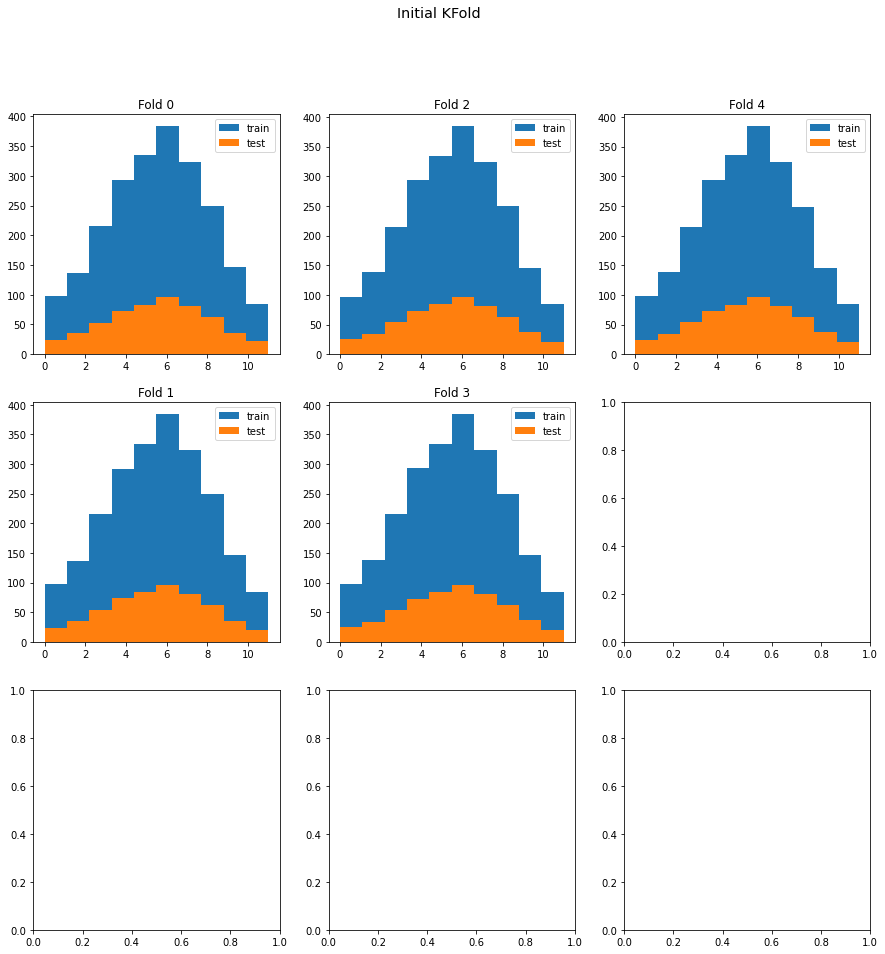

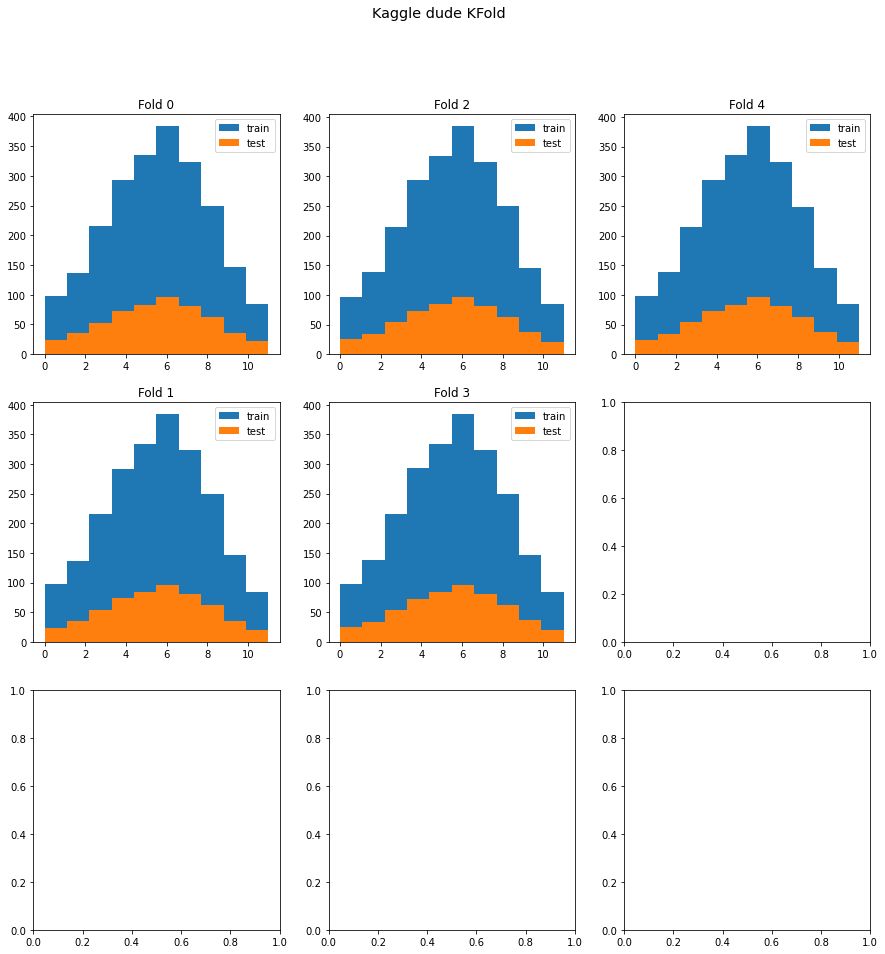

In [52]:
train_data['Fold'] = -1
fig, ax = plt.subplots(
    int(np.ceil(np.sqrt(args.nfolds))),
    int(np.ceil(np.sqrt(args.nfolds))),
    figsize=(15,15))
st = fig.suptitle("Initial KFold", fontsize="x-large")

fig2, ax2 = plt.subplots(
    int(np.ceil(np.sqrt(args.nfolds))),
    int(np.ceil(np.sqrt(args.nfolds))),
    figsize=(15,15))
st2 = fig2.suptitle("Kaggle dude KFold", fontsize="x-large")

for k, (train_idx, valid_idx) in enumerate(kfold.split(X=train_data, y=bins)):
    
    train_data.loc[valid_idx, 'Fold'] = k
    
#     print (train_data['bins'].iloc[train_idx])
    ax[k % 2, k // 2].hist(train_data['bins'].iloc[train_idx].values, label='train')
    ax[k % 2, k // 2].hist(train_data['bins'].iloc[valid_idx].values, label='test')
    ax[k % 2, k // 2].set_title(f"Fold {k}")
    ax[k % 2, k // 2].legend()
    
    args.fold = k

    X_train, X_val = train_data.query(f"Fold != {k}"), train_data.query(f"Fold == {k}")
    y_train, y_val = X_train['target'], X_val['target']
    
    ax2[k % 2, k // 2].hist(X_train['bins'].values, label='train')
    ax2[k % 2, k // 2].hist(X_val['bins'].values, label='test')
    ax2[k % 2, k // 2].set_title(f"Fold {k}")
    ax2[k % 2, k // 2].legend()
    
    
plt.show()